# Predicting Bankruptcy with machine learning

In [1]:
# Import the modules
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
#import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential # try tensorflow.keras.models in case of import error
from keras.layers import Dense # try tensorflow.keras.layers in case of import error
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
# Ordered Dictionary
from collections import OrderedDict
import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

#To perform kFold Cross Validation
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import copy as cp
import seaborn as sns
from typing import Tuple


### Step 1: Read the `accounting.csv` data from the `Resources` folder into a Pandas DataFrame.

In [2]:
# import training dataset

training_df = pd.read_csv(Path("../Resources/training_dataset_original_accounting.csv"))


###  Create the labels set (`y`)  from the “status” column, and then create the features (`X`) DataFrame from the remaining columns.

In [3]:
# split training dataset to X and y

X_train = training_df.drop(columns="status")
y_train = training_df["status"]
display(X_train.tail())
display(y_train[-5:])

,current_assets,cost_of_goods_sold,depreciation_and_amortization,EBITDA,inventory,net_income,total_receivables,market_value,net_sales,total_assets,total_long_term_debt,EBIT,gross_profit,total_current_liabilities,retained_earnings,total_revenue,total_liabilities,total_operationg_expenses
78677,-0.164731,-0.173697,-0.164232,-0.164584,-0.186875,-0.082275,-0.197599,-0.144340,-0.189104,-0.136865,-0.165883,-0.149872,-0.187726,-0.198027,-0.079190,-0.189104,-0.192171,-0.185099
78678,-0.197224,-0.171923,-0.120548,-0.086792,-0.187901,0.000241,-0.173823,-0.156771,-0.173462,-0.077504,0.014688,-0.064219,-0.142402,-0.177631,-0.058828,-0.173462,-0.110911,-0.182180
78679,-0.207810,-0.170815,-0.086112,-0.147966,-0.187625,-0.103376,-0.182913,-0.153984,-0.183612,-0.086769,-0.011874,-0.161599,-0.177156,-0.178435,-0.059055,-0.183612,-0.124581,-0.182009
78680,-0.189677,-0.171101,-0.085694,-0.152876,-0.188160,-0.118357,-0.194328,-0.163014,-0.184279,-0.087553,-0.008775,-0.168392,-0.178594,-0.179713,-0.062258,-0.184279,-0.123779,-0.181826
78681,-0.203071,-0.170844,-0.085891,-0.153825,-0.188067,-0.142493,-0.180389,-0.166188,-0.184394,-0.096126,-0.027871,-0.169583,-0.179564,-0.180613,-0.070257,-0.184394,-0.131726,-0.181774


78677    0
78678    0
78679    0
78680    0
78681    0
Name: status, dtype: int64

In [4]:

# Import the SMOTE module form imbalanced-learn
from imblearn.over_sampling import SMOTE

# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
smote_oversampler = SMOTE( random_state=1)


# Fit the original training data to the random_oversampler model
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [5]:
# Count the distinct values of the resampled labels data
y_resampled.value_counts()


0    73462
1    73462
Name: status, dtype: int64

In [6]:
def prepare_kfold_cv_data(k, X, y, verbose=False):
    X = X.values
    y = y.values
    kf = KFold(n_splits=k, shuffle=False, random_state=None)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for train_index, test_index in kf.split(X):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test

In [7]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy')

In [8]:
# From SVM, instantiate SVC classifier model instance

svm = SVC(kernel= 'rbf', random_state=1, C=0.1)

In [9]:
# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

In [10]:
# eXtreme Gradient Boosting Classifier (XGBClassifier)
xgb_classifier = XGBClassifier()

In [11]:
# creating a dictionary of models
models_dictionary = OrderedDict()

models_dictionary['Random Forest'] = rf_classifier
models_dictionary['Decision Tree'] = dt_classifier
models_dictionary['Extreme Gradient Boosting'] = xgb_classifier
models_dictionary[' Support Vector Machine'] = svm

In [12]:
# perform data modeling
def perform_data_modeling(_models_, X, y, verbose=False, k_folds=4):
    
    # 4 Models
    # 1 datasets 
    # 8 metrics, averaged over all the K-Folds
    model_results = OrderedDict()
    
    # Iterate over the models
    for model_name, clf in _models_.items():
        if verbose: print("-"*120, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
               
                # Calling the 'prepare_kfold_cv_data' returns lists of features and labels 
                # for train and test sets respectively.
                # The number of items in the list is equal to k_folds
        X_train_list, y_train_list, X_test_list, y_test_list = prepare_kfold_cv_data(k_folds, X, y, verbose)

        metrics_results = OrderedDict()
        accuracy_list = np.zeros([k_folds])
        f1score_list = np.zeros([k_folds,2])
        precision_list = np.zeros([k_folds,2])
        recall_list = np.zeros([k_folds,2])
        TN_list = np.zeros([k_folds])
        FP_list = np.zeros([k_folds])
        FN_list = np.zeros([k_folds])
        TP_list = np.zeros([k_folds])                
        
        # Iterate over all the k-folds
        for k_index in range(k_folds):
            X_train = X_train_list[k_index]
            y_train = y_train_list[k_index]
            X_test = X_test_list[k_index]
            y_test = y_test_list[k_index]

            # Fit the model and 
            clf = clf.fit(X_train, y_train)
            y_test_predicted = clf.predict(X_test)

            #code for calculating accuracy 
            _accuracy_ = accuracy_score(y_test, y_test_predicted, normalize=True)
            accuracy_list[k_index] = _accuracy_

            #code for calculating recall 
            _recalls_ = recall_score(y_test, y_test_predicted, average=None)
            recall_list[k_index] = _recalls_

            #code for calculating precision 
            _precisions_ = precision_score(y_test, y_test_predicted, average=None)
            precision_list[k_index] = _precisions_
            
            _f1score_ = f1_score(y_test, y_test_predicted)
            f1score_list[k_index] = _f1score_
            
            #code for calculating confusion matrix 
            _confusion_matrix_ = confusion_matrix(y_test, y_test_predicted)
            TN_list[k_index] = _confusion_matrix_[0][0]
            FP_list[k_index] = _confusion_matrix_[0][1]
            FN_list[k_index] = _confusion_matrix_[1][0]
            TP_list[k_index] = _confusion_matrix_[1][1]
            
            
        # creating a metrics dictionary
        metrics_results['Accuracy'] = np.mean(accuracy_list)
        metrics_results['Precisions'] = np.mean(precision_list, axis=0)
        metrics_results['Recalls'] = np.mean(recall_list, axis=0)
        metrics_results['TN'] = np.mean(TN_list)
        metrics_results['FP'] = np.mean(FP_list)
        metrics_results['FN'] = np.mean(FN_list)
        metrics_results['TP'] = np.mean(TP_list)
        metrics_results['F1Score'] = np.mean(f1score_list, axis=0)
        
        if verbose:
            print('\t\t\tAccuracy:', metrics_results['Accuracy'])
            print('\t\t\tPrecision:', metrics_results['Precisions'])
            print('\t\t\tRecall:', metrics_results['Recalls'])
            print('\t\t\tF1Score:', metrics_results['F1Score'])
            
        model_results[model_name] = metrics_results 
        
    return model_results                

In [ ]:
results = perform_data_modeling(models_dictionary,X_resampled, y_resampled,verbose=True, k_folds=4)

------------------------------------------------------------------------------------------------------------------------ 
 Model: Random Forest Classifier
			Accuracy: 0.8378889766137594
			Precision: [0.64910518 0.6082436 ]
			Recall: [0.60674215 0.92718584]
			F1Score: [0.65362849 0.65362849]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Decision Tree Classifier
			Accuracy: 0.8110315537284583
			Precision: [0.6254259  0.59511358]
			Recall: [0.58128868 0.89672945]
			F1Score: [0.62927707 0.62927707]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Extreme Gradient Boosting Classifier
			Accuracy: 0.7081960741607907
			Precision: [0.5947667  0.56761929]
			Recall: [0.52676245 0.84317414]
			F1Score: [0.55950848 0.55950848]
----------------------------------------------------------------------------------------------------

In [161]:
# perform data modeling
def perform_data_modeling_test(_models_, X, y, verbose=False, k_folds=4):
    
    
    model_results = OrderedDict()
    X = X.values
    y = y.values
    # Iterate over the models
    for model_name, clf in _models_.items():
        if verbose: print("-"*120, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
               
                # Calling the 'prepare_kfold_cv_data' returns lists of features and labels 
                # for train and test sets respectively.
                # The number of items in the list is equal to k_folds
        

        metrics_results = OrderedDict()
        
        no_classes = len(np.unique(y))
    
        actual_classes = np.empty([0], dtype=int)
        predicted_classes = np.empty([0], dtype=int)
        predicted_proba = np.empty([0, no_classes]) 
        # Iterate over all the k-folds
        kfold = KFold(n_splits=k_folds, random_state=42, shuffle=True)
        for train_ndx, test_ndx in kfold.split(X):

            train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

            actual_classes = np.append(actual_classes, test_y)

            clf.fit(train_X, train_y)
            predicted_classes = np.append(predicted_classes, clf.predict(test_X))

           
        sorted_labels =  [0, 1]   
        matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
        
        
        val = np.mat(matrix) 
        classnames = list(set(y))
        df_cm = pd.DataFrame(
                val#, index=status, columns=status, 
            )
        print(df_cm)
      
        plt.figure(figsize=(12.8,6))
        sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
        plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

        plt.show()
        
        print(classification_report(actual_classes, predicted_classes))
       
        
    return model_results  

------------------------------------------------------------------------------------------------------------------------ 
 Model: Random Forest Classifier
       0      1
0  66343   7119
1   4030  69432


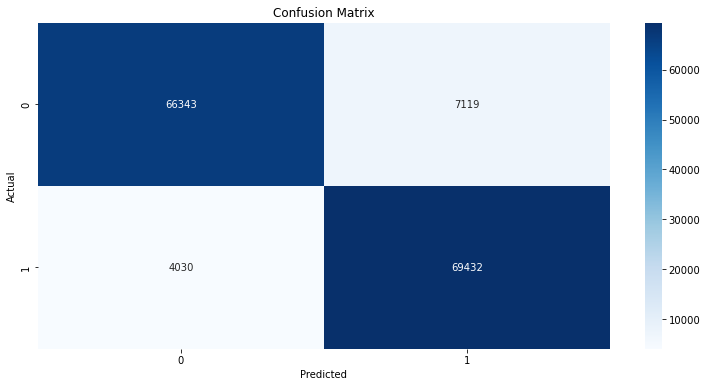

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     73462
           1       0.91      0.95      0.93     73462

    accuracy                           0.92    146924
   macro avg       0.92      0.92      0.92    146924
weighted avg       0.92      0.92      0.92    146924

------------------------------------------------------------------------------------------------------------------------ 
 Model: Decision Tree Classifier
       0      1
0  63056  10406
1   6693  66769


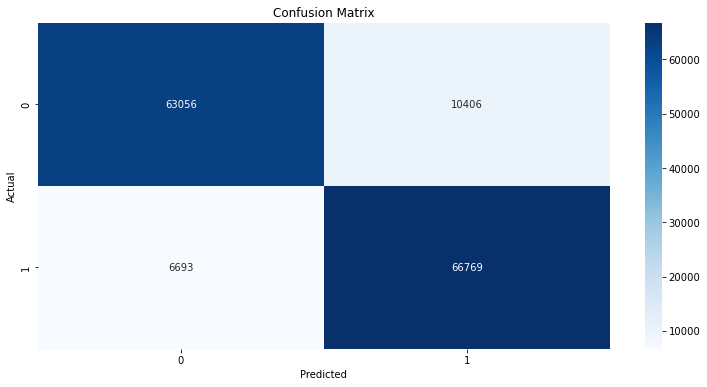

              precision    recall  f1-score   support

           0       0.90      0.86      0.88     73462
           1       0.87      0.91      0.89     73462

    accuracy                           0.88    146924
   macro avg       0.88      0.88      0.88    146924
weighted avg       0.88      0.88      0.88    146924

------------------------------------------------------------------------------------------------------------------------ 
 Model: Extreme Gradient Boosting Classifier
       0      1
0  60241  13221
1   7908  65554


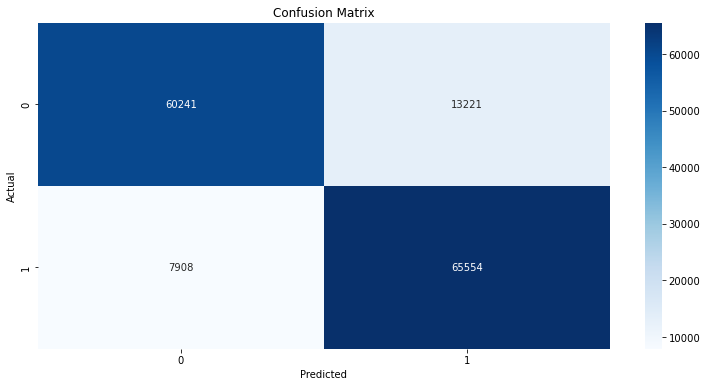

              precision    recall  f1-score   support

           0       0.88      0.82      0.85     73462
           1       0.83      0.89      0.86     73462

    accuracy                           0.86    146924
   macro avg       0.86      0.86      0.86    146924
weighted avg       0.86      0.86      0.86    146924

------------------------------------------------------------------------------------------------------------------------ 
 Model:  Support Vector Machine Classifier


In [ ]:
results = perform_data_modeling_test(models_dictionary,X_resampled, y_resampled,verbose=True, k_folds=4)